# <center>Site-level Study on EU ETS Policy Effects:</center>
## <center>Triple-Outcome Analysis (ETS CO₂ + Reported NOx + Satellite NOx)</center>

## Research question / Hypotheses

**Core question:**
> How do EU ETS carbon market stringency interventions affect verified CO₂ emissions, reported NOx emissions, and satellite-derived NOx proxies around major industrial emitters?

**Triple Outcomes:**
1. **ETS CO₂** (ground-truth): Verified annual emissions from EU ETS registry
2. **Reported NOx** (ground-truth): Administrative NOx emissions from LCP Directive reporting
3. **Satellite NOx** (proxy): Beirle-style flux-divergence NOx estimates from TROPOMI — validates reported NOx and captures local air quality co-benefits

**Sub-questions / hypotheses:**
- *H1:* Allocation shortfall (ratio < 1) induces facilities to reduce combustion, lowering both CO₂ and NOx.
- *H2:* The magnitude of emission reduction correlates with plant characteristics (fuel type, capacity) and local geography.
- *H3:* Satellite NOx provides independent validation of reported NOx and captures air quality co-benefits not reflected in administrative data.
- *H4:* Effects on satellite NOx may be attenuated relative to reported NOx due to measurement noise (~35-45% uncertainty).

## Variables and Causal Structure

We work with a **plant–year panel** indexed by facility *i* and year *t*.

### Triple Outcomes
- **$Y^{CO2}_{it}$**: Verified annual CO₂ emissions from EU ETS registry (tCO₂/yr, log-transformed).
  Ground-truth administrative data with high reliability.
- **$Y^{NOx,rep}_{it}$**: Reported NOx emissions from LCP Directive (tonnes/yr, log-transformed).
  Ground-truth administrative data — primary NOx outcome for policy effect estimation.
- **$Y^{NOx,sat}_{it}$**: Satellite-derived NOx emission proxy (kg/s) via Beirle-style flux-divergence.
  Independent validation of reported NOx and proxy for local air quality co-benefits.

### Treatment (Causal Target)
- **Policy $P_{it}$**: EU ETS stringency at the plant–year level, measured by the
  allocation ratio (free allocation / verified emissions). Values < 1 indicate the
  facility must purchase additional allowances, creating abatement incentives.

### Observed Covariates
- **Plant characteristics $X_{it}$**: Time-varying capacity (MW) and fuel mix shares.
  Used as controls for **ALL outcomes**.
- **Geographic context $G_i$**: High-dimensional AlphaEarth embeddings (64-dim) encoding
  land use, infrastructure, and climate patterns. Used as controls for **Satellite NOx only** (see below).

### Unobserved Variables
- **$U_i$**: Plant-level time-invariant unobservables (baseline technology, combustion efficiency).
- **$U_{it}$**: **Plant-level time-varying unobservables**—the key identification challenge.
  Includes dispatch/utilization, maintenance status, operational efficiency changes.
- **$U_{rt}$**: Region–time effects (electricity demand, fuel prices, regional policy enforcement).

### Why Triple Outcomes?

1. **ETS CO₂** is ground-truth for carbon emissions (primary outcome)
2. **Reported NOx** is ground-truth for NOx emissions — captures pollution co-benefits of carbon policy
3. **Satellite NOx** provides:
   - Independent validation (robust to reporting compliance issues)
   - Local air quality proxy (captures ambient concentration effects, not just stack emissions)
   - Consistent effects across reported and satellite NOx strengthen causal claims

### Satellite NOx Methodology Note

We use a **5km integration radius** instead of Beirle's standard 15km. This modification was motivated 
by poor correlation (r < 0) between satellite NOx and reported NOx at 15km, which improved substantially 
(r ≈ +0.49 at conservative DL) at 5km. The smaller radius reduces contamination from nearby sources 
and better isolates facility-level emissions.

This aligns with the DAG: $G_i \to Y^{NOx,sat}_{it}$ only, not $G_i \to Y^{CO2}_{it}$ or $G_i \to Y^{NOx,rep}_{it}$.

```mermaid
flowchart LR
  %% === UNOBSERVED ===
  subgraph Unobserved
    direction TB
    Ui["U_i: time-invariant (technology, efficiency)"]
    Uit["U_it: time-varying (dispatch, maintenance)"]
    Urt["U_rt: region–time (demand, prices)"]
  end

  %% === OBSERVED ===
  subgraph Observed Controls
    direction TB
    X["X_it: capacity, fuel mix"]
    G["G_it: AlphaEarth embeddings"]
    W["W_it: wind (measurement only)"]
  end

  %% === TREATMENT ===
  subgraph Treatment
    A["A_it: Free allocation (predetermined Feb)"]
    P["P_it: Allocation ratio = A/Y"]
  end

  %% === TRIPLE OUTCOMES ===
  subgraph "Triple Outcomes"
    Y_CO2["Y^CO2_it: Verified ETS emissions"]
    Y_NOx_rep["Y^NOx,rep_it: Reported NOx (LCP)"]
    Y_NOx_sat["Y^NOx,sat_it: Satellite NOx proxy"]
  end

  %% === CAUSAL ARROWS ===

  %% Time-invariant unobserved → absorbed by facility FE
  Ui --> Y_CO2
  Ui --> Y_NOx_rep
  Ui --> Y_NOx_sat
  Ui -.->|"absorbed by facility FE"| A

  %% Plant-level time-varying unobserved (KEY CHALLENGE)
  Uit --> Y_CO2
  Uit --> Y_NOx_rep
  Uit --> Y_NOx_sat
  Urt --> Uit

  %% Region-time effects → absorbed by Region×Year FE
  Urt -.->|"absorbed by region×year FE"| A
  Urt --> Y_CO2
  Urt --> Y_NOx_rep
  Urt --> Y_NOx_sat

  %% Observed controls
  X --> Y_CO2
  X --> Y_NOx_rep
  X --> Y_NOx_sat
  
  %% AlphaEarth: affects satellite retrieval quality (background, terrain AMF)
  %% Does NOT affect administrative ETS or LCP reporting
  G --> Y_NOx_sat
  
  %% Wind: ONLY affects satellite measurement (advection calculation)
  %% Does NOT affect administrative data (ETS or LCP)
  W --> Y_NOx_sat

  %% === TREATMENT PATHWAY (NO CYCLE) ===
  A --> P
  Y_CO2 -.->|"ex-post denominator"| P
  
  %% CAUSAL EFFECTS OF INTEREST
  P ==>|"β_CO2 (causal)"| Y_CO2
  P ==>|"β_NOx,rep"| Y_NOx_rep
  P ==>|"β_NOx,sat"| Y_NOx_sat

  %% Mediation: policy affects dispatch (potential mechanism)
  P -.->|"mediation via dispatch"| Uit
```

---

## Controls Included in Each Outcome

| Variable | ETS CO₂ | Reported NOx | Satellite NOx | Reason |
|----------|---------|--------------|---------------|--------|
| **AlphaEarth** $G_i$ | ❌ No | ❌ No | ✅ Yes | Administrative data unaffected by geography; satellite retrieval depends on terrain, land use (AMF), urban background |
| **Wind** $W_{it}$ | ❌ No | ❌ No | ✅ Yes | Administrative data is reported mass balance; Beirle flux-divergence uses wind for advection calculation |
| **Capacity/Fuel** $X_{it}$ | ✅ Yes | ✅ Yes | ✅ Yes | All outcomes reflect combustion intensity |

---

## Identification Strategy

### What We Control For

| Variable | Absorbed By | Rationale |
|----------|-------------|-----------|
| $U_i$ (time-invariant) | Facility FE | Technology, location, baseline efficiency |
| $U_{rt}$ (region-time) | Region×Year FE | Demand shocks, fuel prices, regional policy |
| $X_{it}$ (observed) | Controls | Capacity, fuel mix |
| $G_i$ (geography) | AlphaEarth embeddings | Satellite retrieval context (satellite NOx only) |

### What We Do NOT Control For: $U_{it}$

Plant-level time-varying unobservables ($U_{it}$) include dispatch, maintenance, and efficiency changes.
We deliberately do not control for these because:

1. **Dispatch as confounder**: Regional demand → higher dispatch → more emissions → lower $R_{it}$.
   Same demand → more combustion → higher NO₂. This creates spurious correlation.

2. **Dispatch as mediator**: Policy affects dispatch via carbon costs in bids (higher costs → higher bids →
   lower dispatch probability). Thus $P_{it} \to U_{it} \to Y_{it}$. Controlling for $U_{it}$ blocks
   this pathway and biases $\hat{\beta}$ toward zero.

3. **Facility×Year FE infeasible**: Would absorb all within-facility-year variation, including treatment.

### Our Solution: Region×Year FE

Region×Year FE absorbs the *common regional component* of $U_{it}$ (since dispatch responds to
regional demand/prices) without estimating facility-specific parameters. The identifying variation:

> *Within the same region and year, do facilities with different allocation ratios show different emissions?*

This leaves **facility-specific deviations** in $U_{it}$ as residual confounding (e.g., idiosyncratic
outages, plant-specific demand). These are plausibly second-order and orthogonal to allocation ratio
conditional on capacity and fuel mix controls.

---

## Analysis Methodology

### Treatment Definition

**Continuous Treatment**: `eu_alloc_ratio = allocated_allowances / verified_emissions`
- Ratio < 1 → Facility must purchase additional allowances (treated)
- Ratio ≥ 1 → Facility has sufficient free allocation (control/less treated)

### Clustering Strategy

We use **NUTS2 regions** (Eurostat administrative units) for spatial clustering:
1. **Clustered standard errors** — accounts for within-region correlation in errors
2. **Region × Year fixed effects** — absorbs region-specific time shocks (electricity demand, fuel prices, policy enforcement)

### Sample Definitions

| Sample | Description | Used For |
|--------|-------------|----------|
| **Full ETS** | All facilities with valid ETS emissions | ETS CO₂ |
| **LCP Reported** | Facilities with valid LCP NOx reporting | Reported NOx |
| **Satellite NOx** | Satellite NOx ≥ 0.01 kg/s (detection limit) | Satellite NOx |

**NOTE**: We use a **5km integration radius** (vs Beirle's 15km standard) and a **permissive detection limit of 0.01 kg/s** (vs Beirle's 0.04-0.11 kg/s). This maximizes statistical power but is well below validated thresholds, so measurement noise likely attenuates treatment effects toward zero.

**Validation**: Correlation between satellite and reported NOx is weak in full sample (r=0.03), but improves to r=0.37 (log-log) for non-urban, non-interfered facilities (n=266), confirming the satellite proxy captures true signal under clean measurement conditions.

### Four Core Specifications (TWFE)

| # | Outcome | Sample | Embeddings | Estimator |
|---|---------|--------|------------|-----------|
| **1** | ETS CO₂ | Full ETS | None | TWFE |
| **2** | Reported NOx | LCP Reported | None | TWFE |
| **3** | Satellite NOx | DL ≥0.01 | PCA (10 dims) | TWFE |
| **4** | Satellite NOx | DL ≥0.01 | PLS (10 dims) | TWFE |

### Heterogeneity Analysis

**Split-sample** (separate regressions per group):
- Electricity sector vs other
- Urban vs rural (SMOD ≥22 = semi-dense urban+)
- By dominant fuel type (Coal, Gas, Oil, Biomass)
- Top 5 countries
- Top 5 PyPSA clusters (electricity only)

**Continuous interactions** (treatment × characteristic):
- Fuel shares: `Treatment × share_coal`, `Treatment × share_gas`, etc.
- Capacity: `Treatment × capacity_mw` (standardized)
- Urbanization: `Treatment × urban` (binary)

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# =============================================================================
# COLUMN CONSTANTS
# =============================================================================
FAC_ID_COL = "idx"
YEAR_COL = "year"
CLUSTER_COL = "nuts2_region"
PYPSA_CLUSTER_COL = "pypsa_cluster"
ALLOC_RATIO_COL = "eu_alloc_ratio"
ETS_CO2_COL = "eu_verified_tco2"
LOG_ETS_CO2_COL = "log_ets_co2"
REPORTED_NOX_COL = "reported_nox_tonnes"
LOG_REPORTED_NOX_COL = "log_reported_nox"
NOX_OUTCOME_COL = "beirle_nox_kg_s"
NOX_SE_COL = "beirle_nox_kg_s_se"
IN_URBAN_AREA_COL = "in_urban_area"
URBANIZATION_DEGREE_COL = "urbanization_degree"
IS_ELECTRICITY_COL = "is_electricity"

# =============================================================================
# DATA PATHS (adjust if running from different directory)
# =============================================================================
DATA_DIR = Path("../data/out")
STATIC_PATH = DATA_DIR / "facilities_static.parquet"
YEARLY_PATH = DATA_DIR / "facilities_yearly.parquet"
BEIRLE_PATH = DATA_DIR / "beirle_panel.parquet"

# =============================================================================
# ANALYSIS PARAMETERS
# =============================================================================

# Time range
START_YEAR = 2018
END_YEAR = 2023

# Treatment
TREATMENT_COL = ALLOC_RATIO_COL        # "eu_alloc_ratio"
TREATMENT_THRESHOLD = 1.0               # Treated if ratio < 1

# Triple Outcomes
OUTCOMES = {
    "ETS_CO2": ETS_CO2_COL,              # Verified CO₂ Emissions (tCO2e)
    "Reported_NOx": REPORTED_NOX_COL,    # LCP reported NOx (tonnes/yr)
    "Satellite_NOx": NOX_OUTCOME_COL,    # Beirle-style satellite NOx (kg/s)
}

# =============================================================================
# CONTROLS
# =============================================================================
# Base controls: applied to ALL outcomes
CONTROLS = ["capacity_mw", "share_coal", "share_gas"]

# NOTE: AlphaEarth embeddings (emb_*) are stored in beirle_panel.parquet and are
# automatically added as controls for SATELLITE NOx outcome ONLY by run_nox_analysis().
# They are NOT used for ETS CO₂ or Reported NOx because:
#   1. These are administrative data - geographic context doesn't affect measurement
#   2. Geographic confounders are absorbed by Facility FE and Region×Year FE
# See DAG: G_i → Y^Satellite_NOx only, not G_i → Y^CO2 or Y^Reported_NOx

# Clustering: NUTS2 regions (primary)
# PyPSA clusters available for electricity heterogeneity via PYPSA_CLUSTER_COL

# Sample restrictions
MIN_YEARS_PER_FACILITY = 3

# Heterogeneity dimensions
HETEROGENEITY_VARS = {
    "urbanization": IN_URBAN_AREA_COL,    # Urban vs rural
    "electricity": IS_ELECTRICITY_COL,     # Electricity generators (activity codes 1, 20)
    "fuel_coal": "share_coal",             # High coal (>0.5) vs other
    "capacity": "capacity_mw",             # Above/below median
}

print("Parameters configured:") 
print(f"  Years: {START_YEAR}-{END_YEAR}")
print(f"  Treatment: {TREATMENT_COL} < {TREATMENT_THRESHOLD}")
print(f"  Outcomes: {list(OUTCOMES.keys())}")
print(f"  Base controls: {CONTROLS}")
print(f"  Satellite NOx-only controls: AlphaEarth embeddings (64 dims, auto-added)")
print(f"  Primary clustering: NUTS2 regions ({CLUSTER_COL})")
print(f"  Data paths: {DATA_DIR}")

Parameters configured:
  Years: 2018-2023
  Treatment: eu_alloc_ratio < 1.0
  Outcomes: ['ETS_CO2', 'Reported_NOx', 'Satellite_NOx']
  Base controls: ['capacity_mw', 'share_coal', 'share_gas']
  Satellite NOx-only controls: AlphaEarth embeddings (64 dims, auto-added)
  Primary clustering: NUTS2 regions (nuts2_region)
  Data paths: ../data/out


### Load Data (ETS + Satellite outcomes merged)

In [12]:
from data import load_analysis_panel, load_facilities_static

# Load static attributes (includes is_electricity, nuts2_region, etc.)
static = load_facilities_static(STATIC_PATH)

# Load panel with satellite outcomes included
panel = load_analysis_panel(
    static_path=STATIC_PATH,
    yearly_path=YEARLY_PATH,
    beirle_path=BEIRLE_PATH,
    include_satellite=True
)

print(f"\nPanel: {len(panel)} obs, {panel[FAC_ID_COL].nunique()} facilities")
print(f"Years: {panel[YEAR_COL].min()} - {panel[YEAR_COL].max()}")

print(f"\nStatic attributes:")
print(f"  is_electricity: {static[IS_ELECTRICITY_COL].sum()} / {len(static)} are electricity generators")
if CLUSTER_COL in static.columns:
    print(f"  {CLUSTER_COL}: {static[CLUSTER_COL].nunique()} unique regions")

print(f"\nAvailable outcomes:")
print(f"  ETS CO₂: {ETS_CO2_COL} → {panel[ETS_CO2_COL].notna().sum()} valid obs")
if REPORTED_NOX_COL in panel.columns:
    print(f"  Reported NOx: {REPORTED_NOX_COL} → {panel[REPORTED_NOX_COL].notna().sum()} valid obs")
if NOX_OUTCOME_COL in panel.columns:
    print(f"  Satellite NOx: {NOX_OUTCOME_COL} → {panel[NOX_OUTCOME_COL].notna().sum()} valid obs")

Loaded 521 facilities from facilities_static.parquet
Loaded 521 facilities from facilities_static.parquet
Loaded 2819 obs from facilities_yearly.parquet
Loaded 1430 satellite obs from beirle_panel.parquet
Satellite outcomes: 1317 obs with valid NOx data
AlphaEarth embeddings: 64 dims, 1317 obs (NOx analysis only)
Panel: 2819 obs, 521 facilities, 2018-2023

Panel: 2819 obs, 521 facilities
Years: 2018 - 2023

Static attributes:
  is_electricity: 421 / 521 are electricity generators
  nuts2_region: 82 unique regions

Available outcomes:
  ETS CO₂: eu_verified_tco2 → 2819 valid obs
  Reported NOx: reported_nox_tonnes → 2819 valid obs
  Satellite NOx: beirle_nox_kg_s → 1317 valid obs


## 2. Data Preparation and Treatment Construction

### Build Treatment Variables

In [13]:
from data import build_treatment_variables, apply_sample_filters

# Continuous: eu_alloc_ratio (already in data)
# Discrete: treated = 1 if ratio < 1, cohort = first year treated
panel = build_treatment_variables(
    panel, 
    treatment_col=TREATMENT_COL,
    threshold=TREATMENT_THRESHOLD
)

# Apply sample filters for ETS CO₂ analysis
# NOTE: apply_ets_filter=True applies emissions filter (≥100 ktCO₂/yr) **UNUSED IN PAPER**
# This filter is specific to ETS CO₂ outcome and should NOT be used for satellite NOx
panel = apply_sample_filters(
    panel, 
    min_years=MIN_YEARS_PER_FACILITY,
    year_range=(START_YEAR, END_YEAR),
    require_outcome=True,
    outcome_col=ETS_CO2_COL,
    apply_ets_filter=False,  # Apply emissions filter for ETS CO₂ analysis
)

# Map is_electricity from static to panel
if IS_ELECTRICITY_COL in static.columns and IS_ELECTRICITY_COL not in panel.columns:
    elec_map = static.set_index(FAC_ID_COL)[IS_ELECTRICITY_COL]
    panel[IS_ELECTRICITY_COL] = panel[FAC_ID_COL].map(elec_map) # type: ignore
    print(f"\nMapped is_electricity to panel: {panel[IS_ELECTRICITY_COL].sum()} electricity facility-years")

Treatment: 457 ever-treated, 64 never-treated
Cohorts: 6
Filters: 2819 → 2819 obs (521 facilities)


In [14]:
# =============================================================================
# Panel Summary
# =============================================================================
print(f"\nFinal panel:")
print(f"  Observations: {len(panel)}")
print(f"  Facilities: {panel[FAC_ID_COL].nunique()}")
print(f"  Years: {panel[YEAR_COL].min()}-{panel[YEAR_COL].max()}")
print(f"  Treated (ever): {(panel.groupby(FAC_ID_COL)['treated'].max() > 0).sum()}") # type: ignore
print(f"  Never treated: {(panel.groupby(FAC_ID_COL)['treated'].max() == 0).sum()}") # type: ignore


Final panel:
  Observations: 2819
  Facilities: 521
  Years: 2018-2023
  Treated (ever): 457
  Never treated: 64


## 3. TWFE Continuous Specifications

Two TWFE specifications for each outcome:
1. **Spec 1**: Facility + Year FE, clustered SEs by NUTS2 region
2. **Spec 2**: Facility + Region×Year FE, clustered SEs by NUTS2 region

In [15]:
from continuous import run_ets_analysis, run_nox_analysis, run_reported_nox_analysis

# =============================================================================
# ETS CO₂ (Full Sample) — Run once
# =============================================================================
print("\n" + "=" * 70)
print("ETS CO₂ ANALYSIS (Full Sample)")
print("=" * 70)
ets_results = run_ets_analysis(
    panel, treatment_col=TREATMENT_COL, controls=CONTROLS,
    cluster_col=CLUSTER_COL, ets_col=LOG_ETS_CO2_COL
)

# =============================================================================
# Reported NOx (LCP Directive) — Administrative data like ETS
# =============================================================================
print("\n" + "=" * 70)
print("REPORTED NOx ANALYSIS (LCP Directive)")
print("=" * 70)
reported_nox_results = run_reported_nox_analysis(
    panel, treatment_col=TREATMENT_COL, controls=CONTROLS,
    cluster_col=CLUSTER_COL, nox_col="log_reported_nox"
)

# =============================================================================
# Satellite NOx — Single DL (≥0.01 kg/s) — Main Specification
# NOTE: Permissive threshold chosen for statistical power; well below Beirle's
# validated limits (0.04-0.11 kg/s), so measurement noise likely attenuates effects.
# =============================================================================
print("\n" + "=" * 70)
print("SATELLITE NOx: Detection Limit (≥0.01 kg/s)")
print("=" * 70)
nox_results = run_nox_analysis(
    panel, treatment_col=TREATMENT_COL, controls=CONTROLS,
    cluster_col=CLUSTER_COL, nox_col=NOX_OUTCOME_COL,
    nox_dl_col="above_dl"
)

# =============================================================================
# Combined Summary Table
# =============================================================================
print("\n" + "=" * 70)
print("TWFE RESULTS SUMMARY")
print("=" * 70)

# Build single combined table
rows = []

# ETS (once)
if "coefficient" in ets_results:
    rows.append({
        "Outcome": "ETS CO₂ (Full Sample)",
        "Coefficient": ets_results["coefficient"],
        "SE": ets_results["se"],
        "P-value": ets_results["pvalue"],
        "95% CI": f"[{ets_results['ci_lower']:.4f}, {ets_results['ci_upper']:.4f}]",
        "N": ets_results["n_obs"]
    })

# Reported NOx
if reported_nox_results and "coefficient" in reported_nox_results:
    rows.append({
        "Outcome": "Reported NOx (LCP)",
        "Coefficient": reported_nox_results["coefficient"],
        "SE": reported_nox_results["se"],
        "P-value": reported_nox_results["pvalue"],
        "95% CI": f"[{reported_nox_results['ci_lower']:.4f}, {reported_nox_results['ci_upper']:.4f}]",
        "N": reported_nox_results["n_obs"]
    })

# Satellite NOx
for key in ["satellite_pca", "satellite_pls"]:
    if key in nox_results and "coefficient" in nox_results[key]:
        r = nox_results[key]
        label = "PCA" if "pca" in key else "PLS"
        rows.append({
            "Outcome": f"Satellite NOx ({label}, DL ≥0.01)",
            "Coefficient": r["coefficient"],
            "SE": r["se"],
            "P-value": r["pvalue"],
            "95% CI": f"[{r['ci_lower']:.4f}, {r['ci_upper']:.4f}]",
            "N": r["n_obs"]
        })

display(pd.DataFrame(rows))


ETS CO₂ ANALYSIS (Full Sample)

ETS VERIFIED CO2 EMISSIONS (GROUND TRUTH)
  Sample: Full ETS panel
  Controls: base only (embeddings NOT used - absorbed by FE)

######################################################################
# Outcome: ETS CO2 (tCO2/yr, log)
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.186267 (SE: 0.030313, p=0.0000)

REPORTED NOx ANALYSIS (LCP Directive)

REPORTED NOx EMISSIONS (LCP DIRECTIVE)
  Sample: Facilities with LCP NOx reporting
  Controls: base only (embeddings NOT used - administrative data)
  Observations with reported NOx: 2,819 / 2,819

######################################################################
# Outcome: Reported NOx (tonnes/yr, log)
######################################################################

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 96 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 96 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.065762 (SE: 0.028270, p=0.0230)

SATELLITE NOx: Detection Limit (≥0.01 kg/s)

NOx Detection Limit Filter (≥0.04 kg/s): 2819 → 650 obs
PCA reduction: 64 → 10 dimensions
  Variance explained: 87.7%
  Valid observations: 650 / 650

SATELLITE NOx (PCA) — Detection Limit: ≥0.04 kg/s
  Controls: base + embeddings PCA (10 dims)

######################################################################
# Outcome: Satellite NOx (PCA, DL ≥0.04 kg/s)
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000031 (SE: 0.000172, p=0.8570)
PLS training: 182 facilities with valid embeddings + target
PLS reduction: 64 → 10 dimensions
  T

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 124 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 124 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000062 (SE: 0.000184, p=0.7376)

TWFE RESULTS SUMMARY


,Outcome,Coefficient,SE,P-value,95% CI,N
0,ETS CO₂ (Full Sample),-0.186267,0.030313,4.960499e-08,"[-0.2457, -0.1269]",2723
1,Reported NOx (LCP),-0.065762,0.028270,2.304163e-02,"[-0.1212, -0.0104]",2723
2,"Satellite NOx (PCA, DL ≥0.01)",-0.000031,0.000172,8.570439e-01,"[-0.0004, 0.0003]",526
3,"Satellite NOx (PLS, DL ≥0.01)",-0.000062,0.000184,7.376179e-01,"[-0.0004, 0.0003]",526


## 4. Callaway-Sant'Anna DiD: NOT POSSIBLE
### **These cells have been kept for completeness/future work.**

I initially planned to complement the TWFE analysis with the **Callaway & Sant'Anna (2021)** estimator, which addresses potential TWFE bias when treatment timing varies and effects are heterogeneous. However, this approach is **not feasible** for this dataset.

### The Problem: No Pre-Treatment Observations

CS-DiD requires observing units *before* they first receive treatment to establish parallel pre-trends. Defining treatment as `eu_alloc_ratio < 1`, the "cohort" is the first year a facility crosses this threshold.

**The EU ETS has operated since 2005.** By the start of our panel (2018), most facilities that would ever face allocation shortfalls were already treated:

| Cohort (First Treatment Year) | Facilities | % of Ever-Treated |
|------------------------------|-----------|-------------------|
| **2018** (first panel year) | 386 | **84.5%** |
| 2019 | 20 | 4.4% |
| 2020 | 9 | 2.0% |
| 2021 | 38 | 8.3% |
| 2022-2023 | 4 | <1% |

With **84.5% of treated facilities already treated in 2018**, there are no pre-treatment observations for the vast majority of units. The CS-DiD estimator cannot identify treatment effects without this variation.

### Why TWFE Still Works

Our continuous TWFE specification does **not** require discrete cohort definitions. It exploits:
- **Within-facility variation** in allocation ratios over time
- **Continuous treatment intensity** rather than binary treatment status

This is valid because:
1. The allocation ratio varies year-to-year within facilities
2. Fixed effects absorb time-invariant confounders
3. Region×Year FE absorbs regional time shocks

### Future Work

Extending the panel backward to **2013-2017** (EU ETS Phase 3) would capture actual first-treatment timing for most facilities, enabling proper event-study analysis with pre-treatment observations.

In [16]:
# =============================================================================
# Validate Cohorts for Callaway-Sant'Anna
# =============================================================================
from discrete import validate_cohorts

# Ensure cohorts are properly constructed (already done in build_treatment_variables)
cohort_validation = validate_cohorts(panel, cohort_col="cohort")

Valid: 6 cohorts, 457 treated, 64 control


In [17]:
from discrete import estimate_callaway_santanna, validate_cohorts
from data import get_absorbing_treatment_sample, identify_treatment_reversers
from embedding_reduction import reduce_embeddings, get_reduced_embedding_cols

# Filter to Absorbing Treatment Sample (drop reversers)
# =============================================================================
# CS-DiD assumes absorbing treatment (once treated, always treated).
# Facilities with treatment reversals violate this assumption and must be dropped.

print("=" * 70)
print("CS-DiD SAMPLE PREPARATION: Absorbing Treatment Filter")
print("=" * 70)

# Show reversal distribution
reversal_info = identify_treatment_reversers(panel, treatment_col=TREATMENT_COL)
print("\nTreatment reversal distribution:")
print(reversal_info["n_reversals"].value_counts().sort_index().to_string())

# Filter to absorbing treatment sample
panel_csdid = get_absorbing_treatment_sample(panel, treatment_col=TREATMENT_COL)

# Validate cohorts on filtered sample
cohort_validation = validate_cohorts(panel_csdid, cohort_col="cohort")

# CS-DiD: ETS CO₂ (Absorbing Treatment Sample)
# =============================================================================
print("\n" + "=" * 70)
print("CS-DiD: ETS CO₂ (Absorbing Treatment Sample)")
print("=" * 70)

csdid_ets = estimate_callaway_santanna(
    panel_csdid, outcome_col=LOG_ETS_CO2_COL, cohort_col="cohort",
    control_group="notyettreated"  # Use not-yet-treated as controls
)

# CS-DiD: Satellite NOx — Single DL (≥0.01 kg/s)
# =============================================================================
print("\n" + "=" * 70)
print("CS-DiD: Satellite NOx (DL ≥0.01 kg/s)")
print("=" * 70)

# Filter to DL (on absorbing treatment sample)
nox_panel = panel_csdid[panel_csdid["above_dl"] == True].copy() if "above_dl" in panel_csdid.columns else panel_csdid.dropna(subset=[NOX_OUTCOME_COL])
print(f"NOx sample (DL ≥0.01, absorbing): {len(nox_panel)} obs, {nox_panel[FAC_ID_COL].nunique()} facilities") # type: ignore

csdid_nox = {}
for emb_method in ["pca", "pls"]:
    print(f"\n--- {emb_method.upper()} Embeddings ---")
    df_reduced = reduce_embeddings(
        nox_panel.copy(), method=emb_method, n_components=10, # type: ignore
        target_col=NOX_OUTCOME_COL if emb_method == "pls" else None
    )
    emb_cols = get_reduced_embedding_cols(df_reduced, method=emb_method)
    xformla = "~ " + " + ".join(emb_cols) if emb_cols else None
    
    csdid_nox[emb_method] = estimate_callaway_santanna(
        df_reduced, outcome_col=NOX_OUTCOME_COL, cohort_col="cohort",
        xformla=xformla, control_group="notyettreated"
    )

# CS-DiD Summary Table
# =============================================================================
print("\n" + "=" * 70)
print("CS-DiD RESULTS SUMMARY (Absorbing Treatment Sample, Not-Yet-Treated Controls)")
print("=" * 70)

rows = []

# ETS
if csdid_ets and "agg_simple" in csdid_ets:
    agg = csdid_ets["agg_simple"]
    rows.append({
        "Outcome": "ETS CO₂ (Absorbing Sample)",
        "ATT": agg["att"],
        "SE": agg["se"],
        "95% CI": f"[{agg['ci'][0]:.4f}, {agg['ci'][1]:.4f}]" if agg["att"] else "N/A",
        "N": csdid_ets.get("n_obs", "")
    })

# Satellite NOx
for emb_method, res in csdid_nox.items():
    if res and "agg_simple" in res:
        agg = res["agg_simple"]
        rows.append({
            "Outcome": f"Satellite NOx ({emb_method.upper()}, DL ≥0.01)",
            "ATT": agg["att"],
            "SE": agg["se"],
            "95% CI": f"[{agg['ci'][0]:.4f}, {agg['ci'][1]:.4f}]" if agg["att"] else "N/A",
            "N": res.get("n_obs", "")
        })

display(pd.DataFrame(rows))

CS-DiD SAMPLE PREPARATION: Absorbing Treatment Filter

Treatment reversal distribution:
n_reversals
0    390
1     65
2     53
3     12
4      1

Absorbing treatment filter (CS-DiD requirement):
  Total facilities: 521
  Reversers dropped: 131 (25.1%)
  Non-reversers kept: 390 (74.9%)
  Observations: 2819 → 2101
Valid: 4 cohorts, 326 treated, 64 control

CS-DiD: ETS CO₂ (Absorbing Treatment Sample)

  Dropping small cohorts (<10 units): [2019, 2020, 2021]
  Remaining cohorts: [np.int64(2018)]

Estimating CS-DiD:
  Outcome: log_ets_co2
  Control group: notyettreated
  Covariates: None
  N obs: 2101, N units: 390
Dropped 1692 units that were already treated in the first period.
  ERROR: exceptions must derive from BaseException

CS-DiD: Satellite NOx (DL ≥0.01 kg/s)
NOx sample (DL ≥0.01, absorbing): 500 obs, 139 facilities

--- PCA Embeddings ---
PCA reduction: 64 → 10 dimensions
  Variance explained: 87.4%
  Valid observations: 500 / 500

  Dropping small cohorts (<10 units): [2019]
  R

""


In [18]:
# =============================================================================
# Event Study Plots (CS-DiD)
# =============================================================================

if 'csdid_ets' in dir() and csdid_ets:
    print("\n" + "=" * 70)
    print("EVENT STUDY: ETS CO₂")
    print("=" * 70)
    
    if "att_gt" in csdid_ets:
        ets_model = csdid_ets["att_gt"]
        try:
            ets_model.aggte("dynamic")
            ets_model.plot_aggte()
            plt.title("Event Study: ETS CO₂ (CS-DiD)")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot ETS event study: {e}")

if 'csdid_nox' in dir() and "pca" in csdid_nox:
    print("\n" + "=" * 70)
    print("EVENT STUDY: Satellite NOx (PCA, DL ≥0.01)")
    print("=" * 70)
    
    if "att_gt" in csdid_nox["pca"]:
        nox_model = csdid_nox["pca"]["att_gt"]
        try:
            nox_model.aggte("dynamic")
            nox_model.plot_aggte()
            plt.title("Event Study: Satellite NOx PCA (CS-DiD, DL ≥0.01)")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Could not plot NOx event study: {e}")


EVENT STUDY: ETS CO₂

EVENT STUDY: Satellite NOx (PCA, DL ≥0.01)


## 5. Heterogeneity Analysis

Examine whether treatment effects vary systematically across facility characteristics.

### Split-Sample Analysis
Separate regressions for each subgroup:
1. **Electricity Sector** (`is_electricity`): EU ETS activity codes 1 or 20
2. **Urbanization**: Urban (SMOD ≥22) vs Rural facilities
3. **Dominant Fuel Type**: Coal, Gas, Oil, Biomass (whichever share is highest)
4. **Country**: Top 5 countries by facility count
5. **PyPSA Clusters** (electricity only): Top 5 grid regions

### Continuous Interaction Analysis
Single regression with treatment × characteristic interactions:
- **Fuel shares**: Treatment effect varies continuously with coal/gas/oil/biomass composition
- **Capacity**: Treatment effect varies with facility size (standardized for interpretability)
- **Urbanization**: Treatment effect differs for urban vs rural (binary interaction)

**Interpretation**: Positive interaction = weaker (less negative) treatment effect for that characteristic

### Specifications (4 Total)
1. ETS CO₂ (Full Sample)
2. Reported NOx (LCP Directive)
3. Satellite NOx (PCA, DL≥0.01)
4. Satellite NOx (PLS, DL≥0.01)

### Split-Sample Dimensions

In [19]:
from diagnostics import run_full_heterogeneity_analysis, display_heterogeneity_results

# Run heterogeneity for all specs: ETS CO₂ + NOx (PCA/PLS)
het_results = run_full_heterogeneity_analysis(
    panel,
    ets_col=LOG_ETS_CO2_COL,
    treatment_col=TREATMENT_COL,
    base_controls=CONTROLS,
    cluster_col=CLUSTER_COL,
    electricity_col=IS_ELECTRICITY_COL,
    urban_col=IN_URBAN_AREA_COL
)

# Display results
display_heterogeneity_results(het_results)

Running heterogeneity: ETS CO₂...

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.210786 (SE: 0.040150, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 78 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 125 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.090196 (SE: 0.026928, p=0.0029)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.154961 (SE: 0.033262, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 129 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 160 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.195293 (SE: 0.049618, p=0.0003)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.206039 (SE: 0.058580, p=0.0011)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 152 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 106 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(


  Coef: -0.444630 (SE: 0.327496, p=0.2076)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.981538 (SE: 0.174035, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 54 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 90 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.104904 (SE: 0.012065, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.250225 (SE: 0.034293, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 12 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.326573 (SE: 0.048863, p=0.0000)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.109272 (SE: 0.014617, p=0.0001)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 3 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.241734 (SE: 0.059378, p=0.0096)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -1.253513 (SE: 0.169227, p=0.0003)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 32 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -1.455593 (SE: 0.238440, p=0.0088)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.246007 (SE: 0.016993, p=0.0439)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.379842 (SE: 0.142599, p=0.0761)


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 12 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(



######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -1.089565 (SE: 0.038705, p=0.0001)

######################################################################
# Outcome: log_ets_co2
######################################################################
TWFE: eu_alloc_ratio -> log_ets_co2

TWFE (Facility + Region×Year FE)
  Formula: log_ets_co2 ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.261709 (SE: 0.060588, p=0.0125)


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 13 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


Running heterogeneity: Reported NOx (LCP)...

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.088711 (SE: 0.030803, p=0.0055)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 78 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 125 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: 0.027913 (SE: 0.043434, p=0.5271)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.044374 (SE: 0.026193, p=0.0977)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 129 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 160 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.080981 (SE: 0.054787, p=0.1460)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.163583 (SE: 0.030601, p=0.0000)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 152 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 106 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(


  Coef: -0.088704 (SE: 0.020314, p=0.0018)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.281410 (SE: 0.113331, p=0.0216)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 54 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 90 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: 0.025578 (SE: 0.022517, p=0.2738)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.176599 (SE: 0.018481, p=0.0000)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 12 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.108016 (SE: 0.066054, p=0.1215)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.011955 (SE: 0.019669, p=0.5602)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 3 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.180132 (SE: 0.043558, p=0.0090)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -2.018202 (SE: 0.396458, p=0.0022)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 32 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.399890 (SE: 0.194017, p=0.1314)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.154705 (SE: 0.010171, p=0.0418)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 12 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.418250 (SE: 0.129685, p=0.0484)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -1.173893 (SE: 0.422633, p=0.0691)

######################################################################
# Outcome: log_reported_nox
######################################################################
TWFE: eu_alloc_ratio -> log_reported_nox

TWFE (Facility + Region×Year FE)
  Formula: log_reported_nox ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas | idx + nuts2_region^year
  Cluster: nuts2_region


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 13 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.187654 (SE: 0.045766, p=0.0148)
Running heterogeneity: Satellite NOx (PCA, DL≥0.01)...
PCA reduction: 64 → 10 dimensions
  Variance explained: 87.7%
  Valid observations: 650 / 650

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000072 (SE: 0.000187, p=0.7021)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: bei

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 105 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 47 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(


  Coef: 0.010949 (SE: 0.000911, p=0.0069)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000046 (SE: 0.000173, p=0.7931)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pc

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 101 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 75 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000697 (SE: 0.000608, p=0.2811)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000128 (SE: 0.000167, p=0.4583)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + p

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 126 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 50 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000098 (SE: 0.000367, p=0.7929)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.008364 (SE: inf, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 49 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            12 variables dropped due to multicollinearity.
            The following variables are dropped: 
    share_coal
    share_gas
    pca_emb_00
    pca_emb_01
    pca_emb_02
    ....
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2229: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor = (_N - _has_intercept) / (_

  Coef: -0.000223 (SE: 0.001597, p=0.8926)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000116 (SE: 0.000151, p=0.4578)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + p

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 64 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 34 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.002741 (SE: 0.000743, p=0.1686)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000293 (SE: 0.000742, p=0.7017)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + 

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 47 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 22 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000335 (SE: 0.000244, p=0.2287)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.005905 (SE: 0.000016, p=0.0018)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + 

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 16 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 7 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: 0.011869 (SE: 0.003514, p=0.1832)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000676 (SE: 0.000000, p=0.0000)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pc

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 3 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            5 variables dropped due to multicollinearity.
            The following variables are dropped: ['capacity_mw', 'pca_emb_06', 'pca_emb_07', 'pca_emb_08', 'pca_emb_09'].
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2229: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor = (_N - _has_intercept) / (_N - _k - _k_fe)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2230: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor_with

  Coef: -0.000545 (SE: 0.001273, p=0.6974)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000580 (SE: inf, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 13 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            5 variables dropped due to multicollinearity.
            The following variables are dropped: ['pca_emb_05', 'pca_emb_06', 'pca_emb_07', 'pca_emb_08', 'pca_emb_09'].
            
  wa

  Coef: -0.016557 (SE: 0.000000, p=0.0000)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.005796 (SE: nan, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 17 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            13 variables dropped due to multicollinearity.
            The following variables are dropped: 
    capacity_mw
    share_coal
    share_gas
    pca_emb_00
    pca_emb_01
    ....
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:798: RuntimeWarning: invalid value encountered in multiply
  self._vcov += self._ssc[x] * self._vcov_crv1(


  Coef: 0.001868 (SE: inf, p=nan)
Running heterogeneity: Satellite NOx (PLS, DL≥0.01)...
PLS training: 182 facilities with valid embeddings + target
PLS reduction: 64 → 10 dimensions
  Training R² (facility-level mean beirle_nox_kg_s): 0.514
  Facilities used for training: 182
  Panel observations with valid embeddings: 650 / 650

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000098 (SE: 0.000196, p=0.6209)

######################################################################
# Outcome: beirle_nox_kg_s
###################

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 105 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 47 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(


  Coef: 0.008656 (SE: 0.001657, p=0.0347)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000021 (SE: 0.000203, p=0.9188)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pl

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 101 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 75 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.001141 (SE: 0.000592, p=0.0860)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000126 (SE: 0.000100, p=0.2306)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + p

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 126 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 50 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000186 (SE: 0.000367, p=0.6199)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.008364 (SE: inf, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 49 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            12 variables dropped due to multicollinearity.
            The following variables are dropped: 
    share_coal
    share_gas
    pls_emb_00
    pls_emb_01
    pls_emb_02
    ....
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2229: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor = (_N - _has_intercept) / (_

  Coef: -0.000734 (SE: 0.002741, p=0.7957)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000162 (SE: 0.000147, p=0.2931)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + p

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 64 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 34 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: 0.002419 (SE: 0.000347, p=0.0907)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000197 (SE: 0.000670, p=0.7749)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + p

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 47 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 22 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: -0.000398 (SE: 0.000200, p=0.1029)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.006024 (SE: 0.001570, p=0.1623)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + 

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 16 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            1 variables dropped due to multicollinearity.
            The following variables are dropped: ['share_coal'].
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 7 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


  Coef: 0.011180 (SE: 0.013161, p=0.5517)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: 0.000676 (SE: 0.000000, p=0.0000)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pl

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 3 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            5 variables dropped due to multicollinearity.
            The following variables are dropped: ['capacity_mw', 'pls_emb_06', 'pls_emb_07', 'pls_emb_08', 'pls_emb_09'].
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2229: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor = (_N - _has_intercept) / (_N - _k - _k_fe)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2230: RuntimeWarning: divide by zero encountered in scalar divide
  _adj_factor_with

  Coef: 0.000478 (SE: 0.002134, p=0.8370)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.000637 (SE: inf, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_0

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 1 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 13 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            5 variables dropped due to multicollinearity.
            The following variables are dropped: ['pls_emb_05', 'pls_emb_06', 'pls_emb_07', 'pls_emb_08', 'pls_emb_09'].
            
  wa

  Coef: -0.024785 (SE: 0.000000, p=0.0000)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 | idx + nuts2_region^year
  Cluster: nuts2_region
  Coef: -0.005796 (SE: nan, p=nan)

######################################################################
# Outcome: beirle_nox_kg_s
######################################################################
TWFE: eu_alloc_ratio -> beirle_nox_kg_s

TWFE (Facility + Region×Year FE)
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + capacity_mw + share_coal + share_gas + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_

/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 17 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:2847: UserWarning: 
            13 variables dropped due to multicollinearity.
            The following variables are dropped: 
    capacity_mw
    share_coal
    share_gas
    pls_emb_00
    pls_emb_01
    ....
            
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/utils/utils.py:226: RuntimeWarning: divide by zero encountered in scalar divide
  G_adj_value = G / (G - 1)
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/feols_.py:798: RuntimeWarning: invalid value encountered in multiply
  self._vcov += self._ssc[x] * self._vcov_crv1(


  Coef: 0.000440 (SE: inf, p=nan)

HETEROGENEITY RESULTS SUMMARY

### ETS CO₂


,Dimension,Group,Coef,SE,P-value,N,Sig
0,Sector,Electricity,-0.2108,0.0402,0.0000,2173,***
1,Sector,Other Sectors,-0.0902,0.0269,0.0029,443,***
2,Location,Urban,-0.1550,0.0333,0.0000,1259,***
3,Location,Rural,-0.1953,0.0496,0.0003,1271,***
4,Fuel,Gas,-0.2060,0.0586,0.0011,1197,***
5,Fuel,Oil,-0.4446,0.3275,0.2076,129,
6,Fuel,Coal,-0.9815,0.1740,0.0000,653,***
7,Fuel,Biomass,-0.1049,0.0121,0.0000,438,***
8,Country,FR,-0.2502,0.0343,0.0000,920,***
9,Country,PL,-0.3266,0.0489,0.0000,743,***



### Reported NOx (LCP)


,Dimension,Group,Coef,SE,P-value,N,Sig
0,Sector,Electricity,-0.0887,0.0308,0.0055,2173,***
1,Sector,Other Sectors,0.0279,0.0434,0.5271,443,
2,Location,Urban,-0.0444,0.0262,0.0977,1259,*
3,Location,Rural,-0.0810,0.0548,0.1460,1271,
4,Fuel,Gas,-0.1636,0.0306,0.0000,1197,***
5,Fuel,Oil,-0.0887,0.0203,0.0018,129,***
6,Fuel,Coal,-0.2814,0.1133,0.0216,653,**
7,Fuel,Biomass,0.0256,0.0225,0.2738,438,
8,Country,FR,-0.1766,0.0185,0.0000,920,***
9,Country,PL,-0.1080,0.0661,0.1215,743,



### Satellite NOx (PCA, DL≥0.01)


,Dimension,Group,Coef,SE,P-value,N,Sig
0,Sector,Electricity,-0.0001,0.0002,0.7021,449,
1,Sector,Other Sectors,0.0109,0.0009,0.0069,49,***
2,Location,Urban,0.0000,0.0002,0.7931,351,
3,Location,Rural,-0.0007,0.0006,0.2811,123,
4,Interference,Isolated (<5km),0.0001,0.0002,0.4583,108,
5,Interference,Interfered (≥5km),-0.0001,0.0004,0.7929,366,
6,Fuel,Oil,-0.0084,inf,nan,6,
7,Fuel,Coal,-0.0002,0.0016,0.8926,139,
8,Fuel,Gas,0.0001,0.0002,0.4578,257,
9,Fuel,Biomass,-0.0027,0.0007,0.1686,34,



### Satellite NOx (PLS, DL≥0.01)


,Dimension,Group,Coef,SE,P-value,N,Sig
0,Sector,Electricity,-0.0001,0.0002,0.6209,449,
1,Sector,Other Sectors,0.0087,0.0017,0.0347,49,**
2,Location,Urban,0.0000,0.0002,0.9188,351,
3,Location,Rural,-0.0011,0.0006,0.0860,123,*
4,Interference,Isolated (<5km),0.0001,0.0001,0.2306,108,
5,Interference,Interfered (≥5km),-0.0002,0.0004,0.6199,366,
6,Fuel,Oil,-0.0084,inf,nan,6,
7,Fuel,Coal,-0.0007,0.0027,0.7957,139,
8,Fuel,Gas,0.0002,0.0001,0.2931,257,
9,Fuel,Biomass,0.0024,0.0003,0.0907,34,*



----------------------------------------------------------------------
Note: Negative coef = policy stringency reduces emissions
      * p<0.1, ** p<0.05, *** p<0.01


### Continuous Interactions

In [24]:
from diagnostics import run_continuous_interaction_analysis
from embedding_reduction import reduce_embeddings, get_reduced_embedding_cols

print("=" * 70)
print("CONTINUOUS INTERACTION ANALYSIS: All Specifications")
print("=" * 70)

interaction_results = {}

# 1. ETS CO₂
print("\n### [1/4] ETS CO₂")
interaction_results["ETS CO₂"] = run_continuous_interaction_analysis(
    panel, outcome_col=LOG_ETS_CO2_COL, treatment_col=TREATMENT_COL,
    controls=CONTROLS, cluster_col=CLUSTER_COL, urban_col=IN_URBAN_AREA_COL
)

# 2. Reported NOx (LCP Directive)
print("\n### [2/4] Reported NOx (LCP)")
nox_sample = panel.dropna(subset=[LOG_REPORTED_NOX_COL])
if len(nox_sample) >= 50:
    interaction_results["Reported NOx (LCP)"] = run_continuous_interaction_analysis(
        nox_sample, outcome_col=LOG_REPORTED_NOX_COL, treatment_col=TREATMENT_COL,
        controls=CONTROLS, cluster_col=CLUSTER_COL, urban_col=IN_URBAN_AREA_COL
    )
else:
    print(f"  Skipping: insufficient data ({len(nox_sample)} obs)")

# 3-4. Satellite NOx: Single DL (0.01 kg/s) with PCA and PLS embeddings
dl_col = "above_dl"
if dl_col in panel.columns:
    sat_nox_sample = panel[panel[dl_col] == True].copy()
    if len(sat_nox_sample) >= 50:
        for i, emb_method in enumerate(["pca", "pls"]):
            spec_name = f"Satellite NOx ({emb_method.upper()}, DL≥0.01)"
            print(f"\n### [{3+i}/4] {spec_name}")
            
            try:
                df_reduced = reduce_embeddings(
                    sat_nox_sample.copy(), method=emb_method, n_components=10, # type: ignore
                    target_col=NOX_OUTCOME_COL if emb_method == "pls" else None
                )
                emb_cols = get_reduced_embedding_cols(df_reduced, method=emb_method)
                controls_with_emb = CONTROLS + emb_cols
                
                interaction_results[spec_name] = run_continuous_interaction_analysis(
                    df_reduced, outcome_col=NOX_OUTCOME_COL, treatment_col=TREATMENT_COL,
                    controls=controls_with_emb, cluster_col=CLUSTER_COL, urban_col=IN_URBAN_AREA_COL
                )
            except Exception as e:
                print(f"  Error: {e}")
    else:
        print(f"  Skipping Satellite NOx: insufficient data ({len(sat_nox_sample)} obs)")
else:
    print(f"  Skipping Satellite NOx: {dl_col} column not found")

# Display all results
print("\n" + "=" * 70)
print("INTERACTION RESULTS SUMMARY")
print("=" * 70)

for spec_name, df in interaction_results.items():
    if df is not None and len(df) > 0:
        print(f"\n### {spec_name}")
        df_display = df.copy()
        df_display["Coef"] = df_display["Coef"].apply(lambda x: f"{x:.6f}")
        df_display["SE"] = df_display["SE"].apply(lambda x: f"{x:.6f}")
        df_display["P-value"] = df_display["P-value"].apply(lambda x: f"{x:.4f}" if x is not None else "N/A")
        display(df_display)

print("\n" + "-" * 70)
print("Interpretation:")
print("  • Treatment (baseline): Effect at mean capacity, zero fuel shares, rural")
print("  • × Fuel: How effect changes per 1-unit (100%) increase in that fuel share")
print("  • × Capacity (std): How effect changes per 1 SD increase in capacity")
print("  • × Urban: Difference in treatment effect for urban vs rural")
print("  • Positive interaction = weaker (less negative) treatment effect")

CONTINUOUS INTERACTION ANALYSIS: All Specifications

### [1/4] ETS CO₂

Continuous Interaction Model:
  Formula: log_ets_co2 ~ eu_alloc_ratio + treat_x_share_coal + treat_x_share_gas + treat_x_share_oil + treat_x_share_biomass + treat_x_capacity + treat_x_urban + share_coal + share_gas + share_oil + share_biomass + capacity_std | idx + nuts2_region^year


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 96 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(



### [2/4] Reported NOx (LCP)

Continuous Interaction Model:
  Formula: log_reported_nox ~ eu_alloc_ratio + treat_x_share_coal + treat_x_share_gas + treat_x_share_oil + treat_x_share_biomass + treat_x_capacity + treat_x_urban + share_coal + share_gas + share_oil + share_biomass + capacity_std | idx + nuts2_region^year

### [3/4] Satellite NOx (PCA, DL≥0.01)
PCA reduction: 64 → 10 dimensions
  Variance explained: 87.7%
  Valid observations: 650 / 650

Continuous Interaction Model:
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + treat_x_share_coal + treat_x_share_gas + treat_x_share_oil + treat_x_share_biomass + treat_x_capacity + treat_x_urban + pca_emb_00 + pca_emb_01 + pca_emb_02 + pca_emb_03 + pca_emb_04 + pca_emb_05 + pca_emb_06 + pca_emb_07 + pca_emb_08 + pca_emb_09 + share_coal + share_gas + share_oil + share_biomass + capacity_std | idx + nuts2_region^year


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 96 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(
/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 124 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(



### [4/4] Satellite NOx (PLS, DL≥0.01)
PLS training: 182 facilities with valid embeddings + target
PLS reduction: 64 → 10 dimensions
  Training R² (facility-level mean beirle_nox_kg_s): 0.514
  Facilities used for training: 182
  Panel observations with valid embeddings: 650 / 650

Continuous Interaction Model:
  Formula: beirle_nox_kg_s ~ eu_alloc_ratio + treat_x_share_coal + treat_x_share_gas + treat_x_share_oil + treat_x_share_biomass + treat_x_capacity + treat_x_urban + pls_emb_00 + pls_emb_01 + pls_emb_02 + pls_emb_03 + pls_emb_04 + pls_emb_05 + pls_emb_06 + pls_emb_07 + pls_emb_08 + pls_emb_09 + share_coal + share_gas + share_oil + share_biomass + capacity_std | idx + nuts2_region^year

INTERACTION RESULTS SUMMARY

### ETS CO₂


/Users/arnav/.pyenv/versions/3.13.7/envs/thesis/lib/python3.13/site-packages/pyfixest/estimation/model_matrix_fixest_.py:215: UserWarning: 124 singleton fixed effect(s) detected. These observations are dropped from the model.
  warnings.warn(


,Variable,Coef,SE,P-value,Sig
0,Treatment (baseline),0.027790,0.121400,0.8196,
1,× Fuel: coal,-0.620978,0.258207,0.0189,**
2,× Fuel: gas,-0.273065,0.114103,0.0195,**
3,× Fuel: oil,-0.513462,0.175159,0.0046,***
4,× Fuel: biomass,-0.153378,0.113721,0.1820,
5,× Capacity (std),0.022577,0.052182,0.6666,
6,× Urban,0.008438,0.044113,0.8489,



### Reported NOx (LCP)


,Variable,Coef,SE,P-value,Sig
0,Treatment (baseline),0.047530,0.054467,0.3860,
1,× Fuel: coal,-0.883073,0.420053,0.0393,**
2,× Fuel: gas,-0.216001,0.055846,0.0003,***
3,× Fuel: oil,-0.434861,0.184025,0.0210,**
4,× Fuel: biomass,-0.007877,0.035209,0.8237,
5,× Capacity (std),-0.009685,0.016021,0.5475,
6,× Urban,-0.018928,0.037456,0.6150,



### Satellite NOx (PCA, DL≥0.01)


,Variable,Coef,SE,P-value,Sig
0,Treatment (baseline),-0.008405,0.003963,0.0441,**
1,× Fuel: coal,0.001511,0.005025,0.7661,
2,× Fuel: gas,0.008266,0.003906,0.0444,**
3,× Fuel: oil,0.009597,0.004099,0.0275,**
4,× Fuel: biomass,0.008504,0.004004,0.0437,**
5,× Capacity (std),0.000939,0.000925,0.3199,
6,× Urban,0.000659,0.000761,0.3946,



### Satellite NOx (PLS, DL≥0.01)


,Variable,Coef,SE,P-value,Sig
0,Treatment (baseline),-0.008134,0.004043,0.0551,*
1,× Fuel: coal,0.001524,0.004811,0.7540,
2,× Fuel: gas,0.008233,0.003994,0.0498,**
3,× Fuel: oil,0.009639,0.004206,0.0306,**
4,× Fuel: biomass,0.008281,0.004054,0.0517,*
5,× Capacity (std),0.001033,0.000951,0.2875,
6,× Urban,0.000439,0.000836,0.6037,



----------------------------------------------------------------------
Interpretation:
  • Treatment (baseline): Effect at mean capacity, zero fuel shares, rural
  • × Fuel: How effect changes per 1-unit (100%) increase in that fuel share
  • × Capacity (std): How effect changes per 1 SD increase in capacity
  • × Urban: Difference in treatment effect for urban vs rural
  • Positive interaction = weaker (less negative) treatment effect


## 6. Embedding Interpretation

The AlphaEarth embeddings (64 dimensions) encode geographic context from satellite imagery—terrain, land use, climate patterns. Understanding what the PCA components capture helps interpret their role as controls for satellite measurement quality.

### Visualization Strategy
1. **Geographic Maps**: Show spatial distribution of each component across Europe
2. **Feature Correlations**: Correlate components with interpretable facility characteristics
3. **PCA Loadings**: Identify which original embedding dimensions drive each component

In [21]:
from embedding_reduction import (
    reduce_embeddings_pca,
    reduce_embeddings_pls,
    plot_component_grid,
    plot_component_correlations
)

# =============================================================================
# Prepare panel with PCA and PLS embeddings (for visualization)
# =============================================================================
# Use the NOx sample with valid embeddings
nox_panel = panel.dropna(subset=[NOX_OUTCOME_COL])
print(f"NOx panel for embedding analysis: {len(nox_panel)} obs, {nox_panel[FAC_ID_COL].nunique()} facilities")

# Fit PCA
nox_panel_pca, pca_model, pca_scaler = reduce_embeddings_pca(
    nox_panel.copy(), 
    n_components=10, 
    return_model=True
)

# Fit PLS (facility-level supervised)
nox_panel_pls, pls_model, pls_scaler = reduce_embeddings_pls(
    nox_panel.copy(),
    target_col=NOX_OUTCOME_COL,
    n_components=10,
    return_model=True
)

NOx panel for embedding analysis: 1317 obs, 367 facilities
PCA reduction: 64 → 10 dimensions
  Variance explained: 84.7%
  Valid observations: 1317 / 1317
PLS training: 367 facilities with valid embeddings + target
PLS reduction: 64 → 10 dimensions
  Training R² (facility-level mean beirle_nox_kg_s): 0.431
  Facilities used for training: 367
  Panel observations with valid embeddings: 1317 / 1317


### Geographic Distribution of PCA Components

Each map shows facilities colored by their value on a PCA component. Spatial patterns reveal what geographic features each component captures (e.g., North/South gradients, coastal vs inland, urban clusters).

PCA Component Maps:


/Users/arnav/Documents/Columbia/S3/Masters Thesis/src/analysis/embedding_reduction.py:654: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  europe_borders = world[world.geometry.centroid.y > 30]  # type: ignore


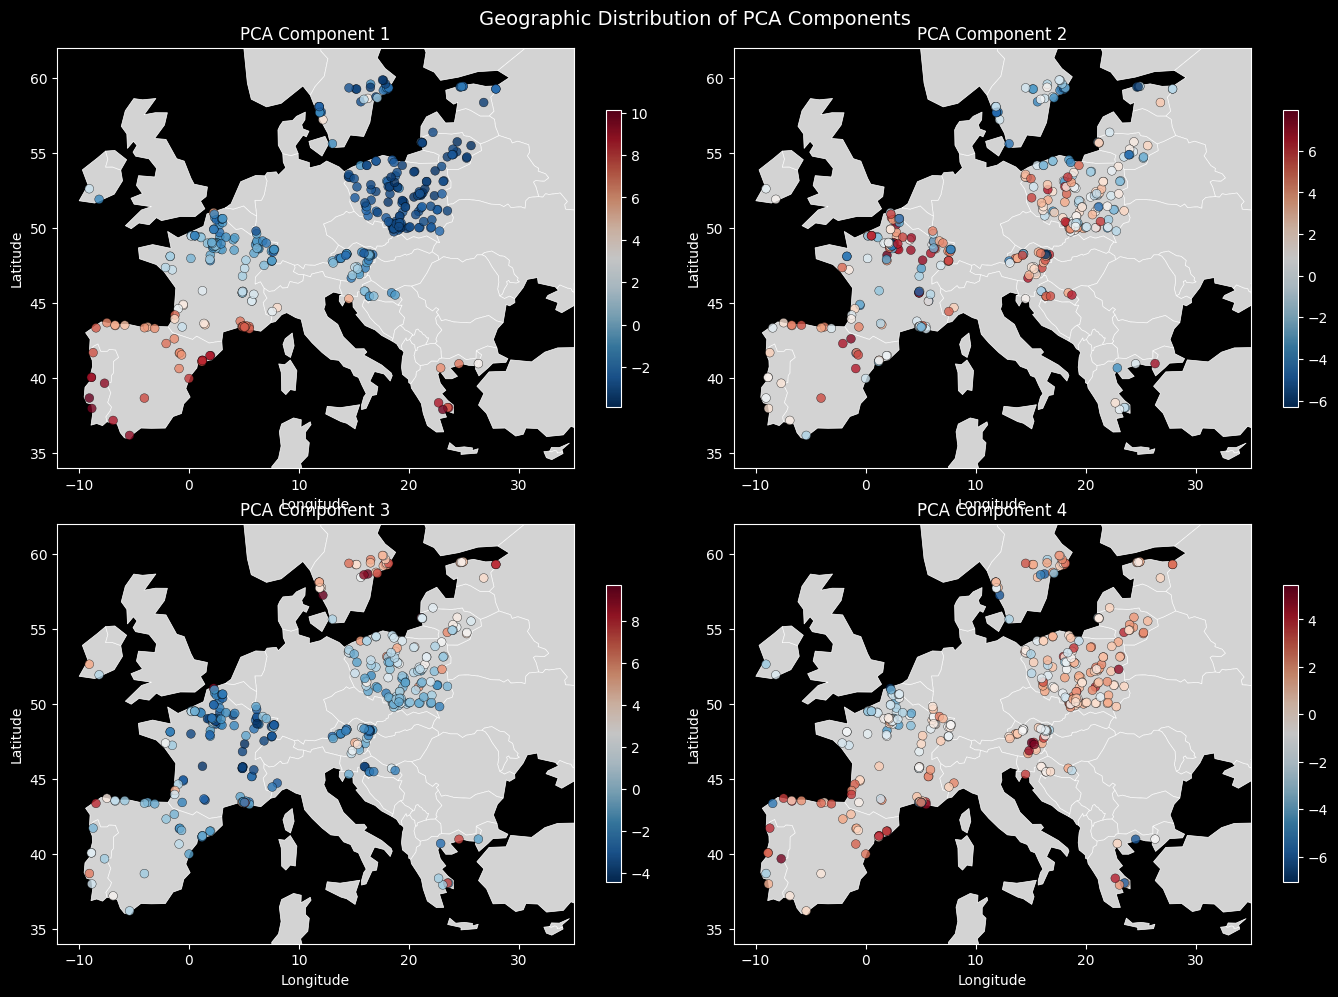


PLS Component Maps:


/Users/arnav/Documents/Columbia/S3/Masters Thesis/src/analysis/embedding_reduction.py:654: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  europe_borders = world[world.geometry.centroid.y > 30]  # type: ignore


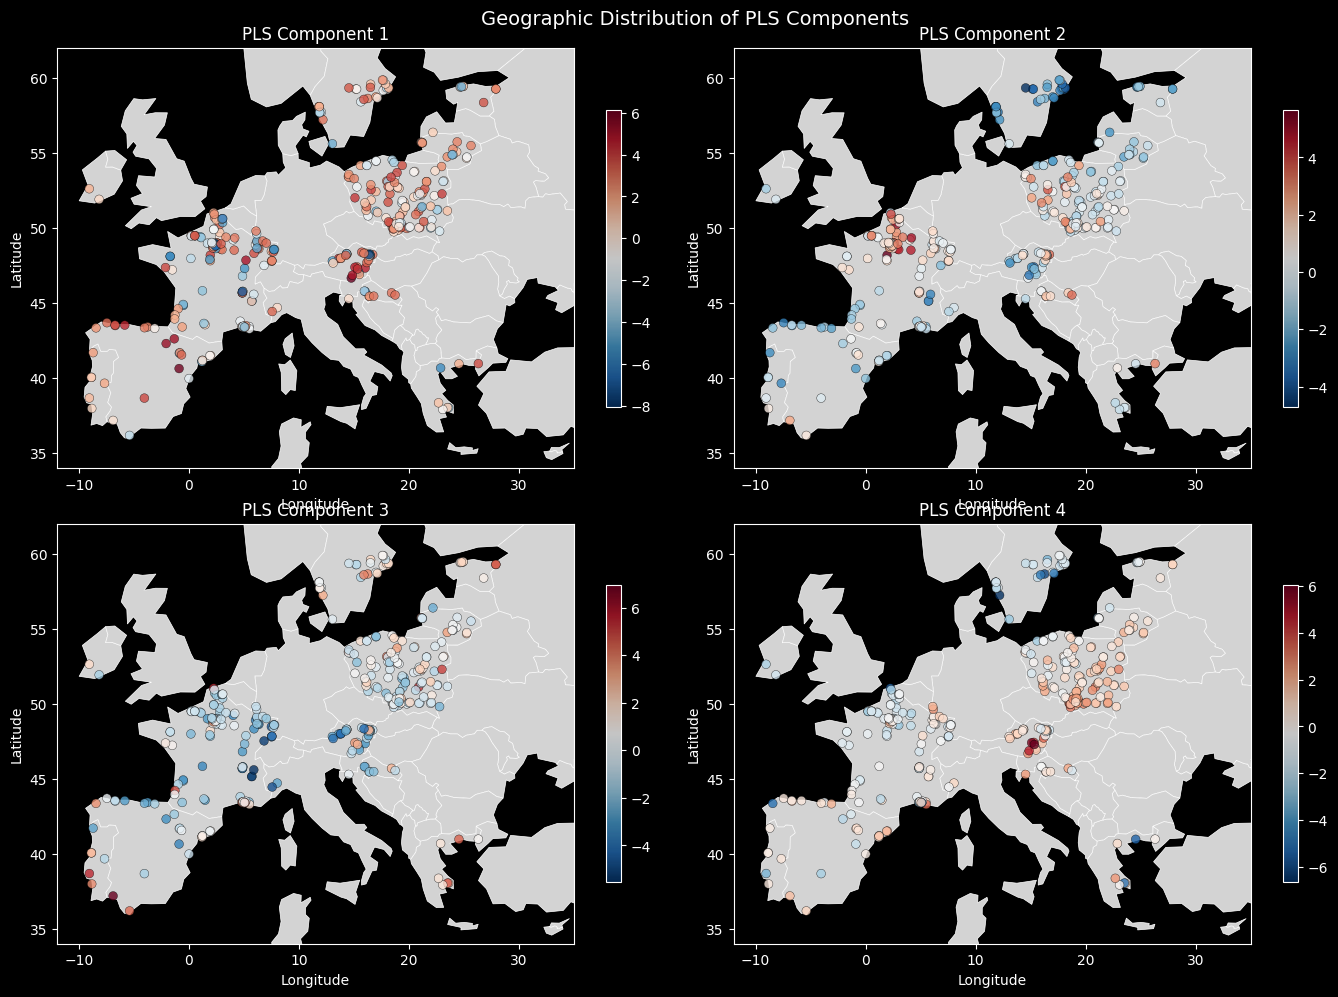

In [22]:
# =============================================================================
# Geographic Map Grid: First 4 Components (PCA and PLS)
# =============================================================================

# PCA Components Map
print("PCA Component Maps:")
fig_maps_pca = plot_component_grid(
    nox_panel_pca, 
    n_components=4, 
    method="pca",
    figsize=(14, 10)
)
plt.savefig("../../docs/paper/figures/pca_component_maps.png", dpi=150, bbox_inches="tight")
plt.show()

# PLS Components Map
print("\nPLS Component Maps:")
fig_maps_pls = plot_component_grid(
    nox_panel_pls, 
    n_components=4, 
    method="pls",
    figsize=(14, 10)
)
plt.savefig("../../docs/paper/figures/pls_component_maps.png", dpi=150, bbox_inches="tight")
plt.show()

### Component Correlations with Interpretable Features

Correlate PCA components with known facility characteristics to understand what geographic patterns each component captures. Strong correlations suggest the component encodes a particular feature of the landscape.

Features for correlation: ['lat', 'lon', 'in_urban_area', 'urbanization_degree', 'is_electricity', 'capacity_mw']

PCA Component Correlations:


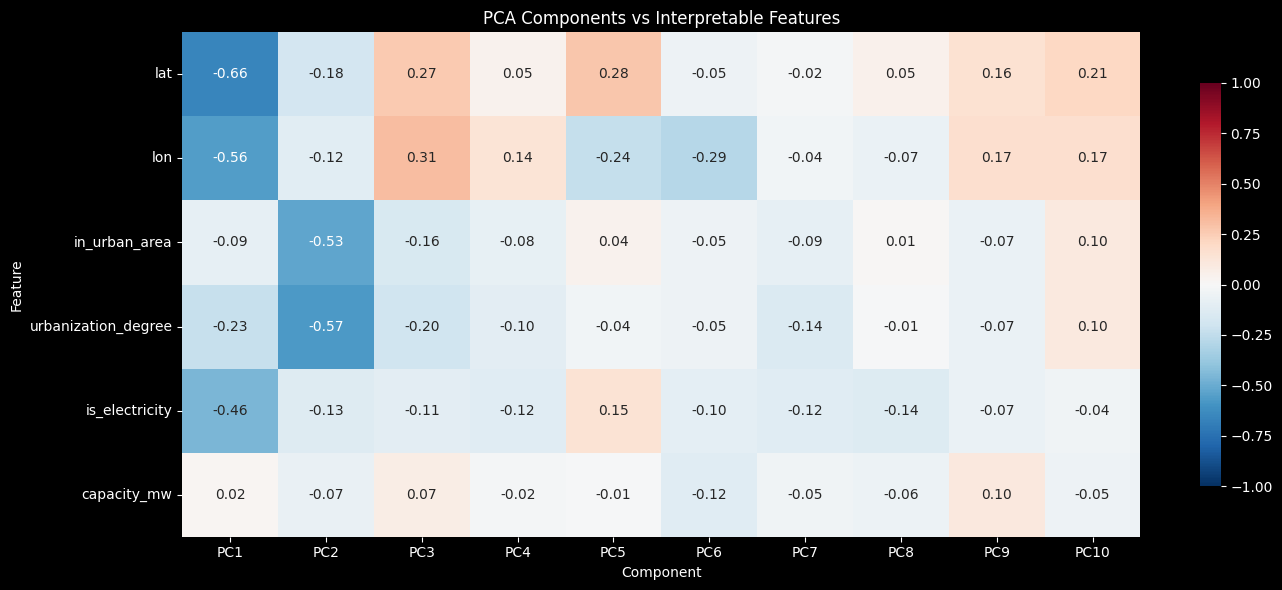


PLS Component Correlations:


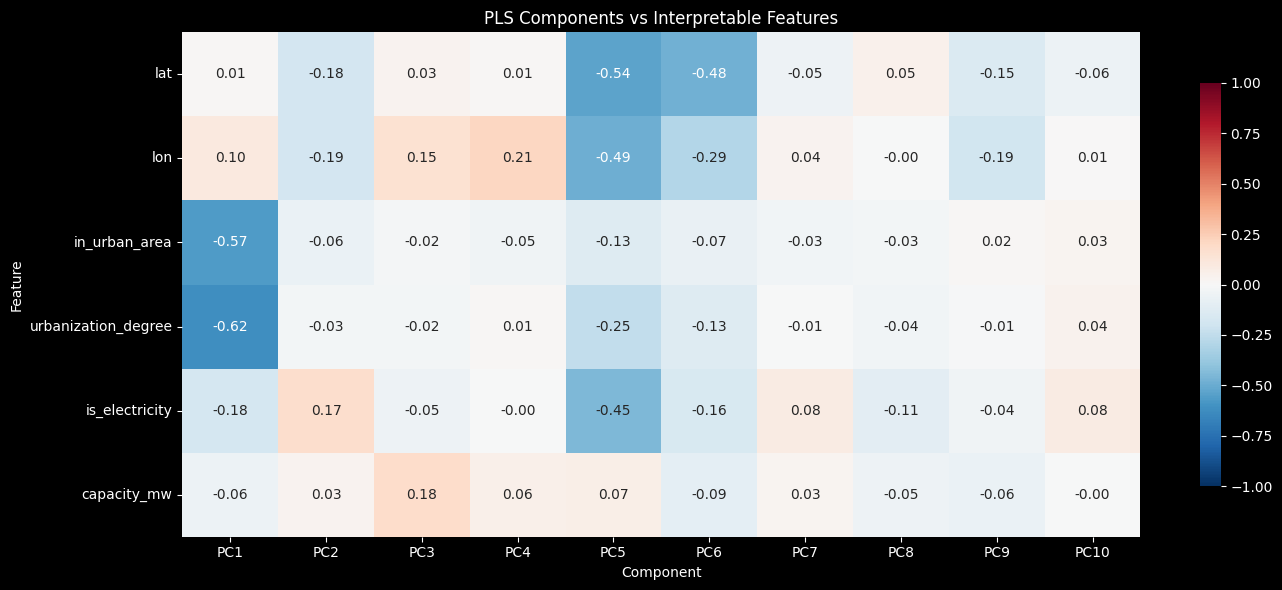

In [23]:
# =============================================================================
# Correlation Heatmap: Components vs Interpretable Features (PCA and PLS)
# =============================================================================

# Define interpretable features to correlate with components
feature_cols = [
    "lat", "lon",                          # Geographic position
    "in_urban_area", "urbanization_degree", # Urban/rural
    "is_electricity",                       # Sector
    "interfered_20km",                      # Spatial interference
    "capacity_mw",                          # Plant size
]

# Filter to features that exist in the panel
feature_cols_available = [c for c in feature_cols if c in nox_panel_pca.columns]
print(f"Features for correlation: {feature_cols_available}")

# PCA Correlations
print("\nPCA Component Correlations:")
fig_corr_pca = plot_component_correlations(
    nox_panel_pca,
    feature_cols=feature_cols_available,
    n_components=10,
    method="pca",
    figsize=(14, 6)
)
plt.savefig("../../docs/paper/figures/pca_component_correlations.png", dpi=150, bbox_inches="tight")
plt.show()

# PLS Correlations
print("\nPLS Component Correlations:")
fig_corr_pls = plot_component_correlations(
    nox_panel_pls,
    feature_cols=feature_cols_available,
    n_components=10,
    method="pls",
    figsize=(14, 6)
)
plt.savefig("../../docs/paper/figures/pls_component_correlations.png", dpi=150, bbox_inches="tight")
plt.show()